# **Deep Learning in Depth [Part 1]**
---

**Required Reading**

[Ian Goodfellow's Deep Learning - Chapter 1, Section 6.2, and Section 8.1](https://www.deeplearningbook.org/contents/intro.html)

**Additional Reading/Viewing**

[Outstanding YouTube Series from 3 Blue 1 Brown](https://www.youtube.com/watch?v=aircAruvnKk)

**Recommended** [Jupyter Theme](https://github.com/dunovank/jupyter-themes) for presenting this notebook:

````
jt -t grade3 -cellw=90% -fs=20 -tfs=20 -ofs=20
````

---

- At this point, I'm going to assume that your pretty comfortable solving **regression** problems with neural networks. If you need a refresher, check out the [Neural Networks Demystified](https://github.com/unccv/neural_networks) module. 
- I'm also going to assume that you're comfortable with the basics of [PyTorch](https://pytorch.org/). If not, check out the Introduction to Pytorch notebook in this repo, and [Jeremy Howard's Excellent Intro](https://pytorch.org/tutorials/beginner/nn_tutorial.html).
- What we haven't discussed in the class yet is how exactly we should go about solving **classification** problems with deep neural networks - how do we predict one of a set of predetermined classes given and image?
- To figure this out, we'll need a classifiction dataset to work with.

![](../graphics/3b1b_mnist.gif)

- We'll start with the popular [mnist dataset](http://yann.lecun.com/exdb/mnist/). (Animation from 3 blue 1 brown's [Great series on deep learning](https://www.youtube.com/watch?v=aircAruvnKk))
- MNIST consists of 70,000 28x28 images of handwritten digits broken apart into 60,000 training and 10,000 testing images.
- Each image comes has been labeled with it's corresponding numerical value
- The images in the training set come from 250 unique writers, and the images in the test set come from a seperate set of 250 unique writers. 
- More information in [LeCun, Bottou, Bengio, and Haffner 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).
- [Great blog post from Christopher Olah on visualizing MNIST](http://colah.github.io/posts/2014-10-Visualizing-MNIST/).

![](../graphics/spacer_small.png)

## 1. Let's Get Some Data
---

- We'll get started by downloading and importing the mnist dataset

In [1]:
from pathlib import Path
import requests
import numpy as np
from matplotlib.pyplot import *

DATA_PATH = Path("../data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

- Let's think throught the dimensions of our data:

In [3]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((50000, 784), (50000,), (10000, 784), (10000,))

![](../graphics/spacer_small.png)

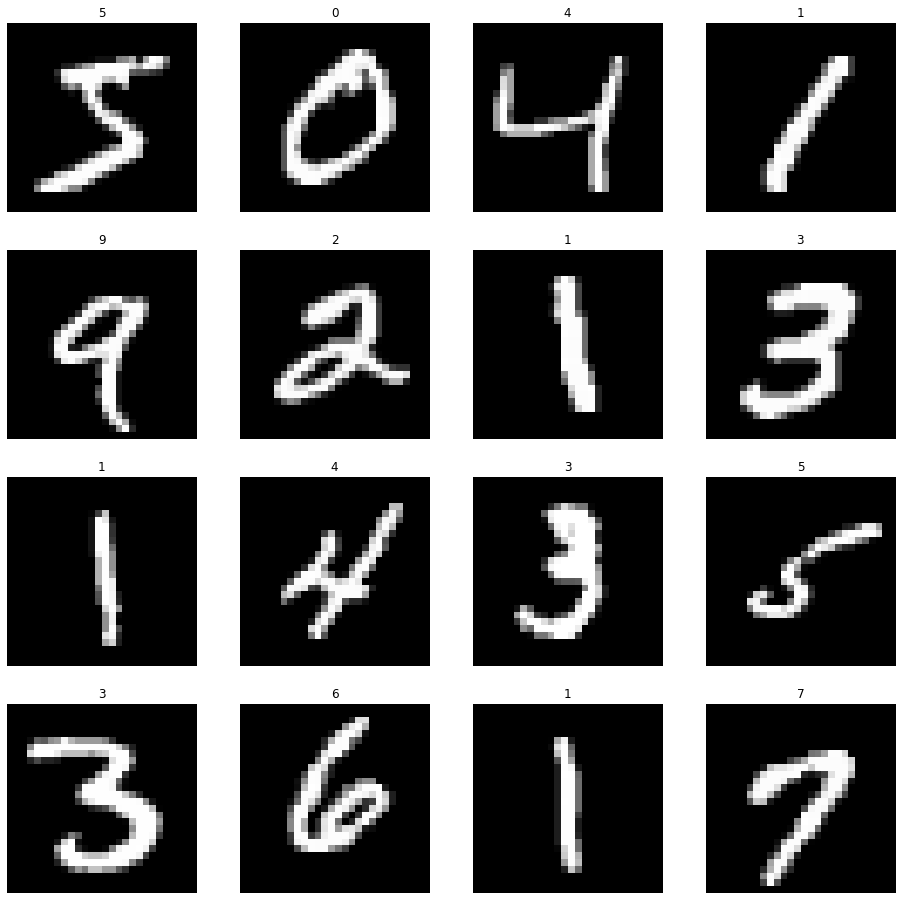

In [4]:
fig = figure(0, (16, 16))
for i in range(16):
    fig.add_subplot(4,4,i+1)
    imshow(x_train[i, :].reshape(28, 28), cmap = 'gray')
    title(str(y_train[i])); axis('off')

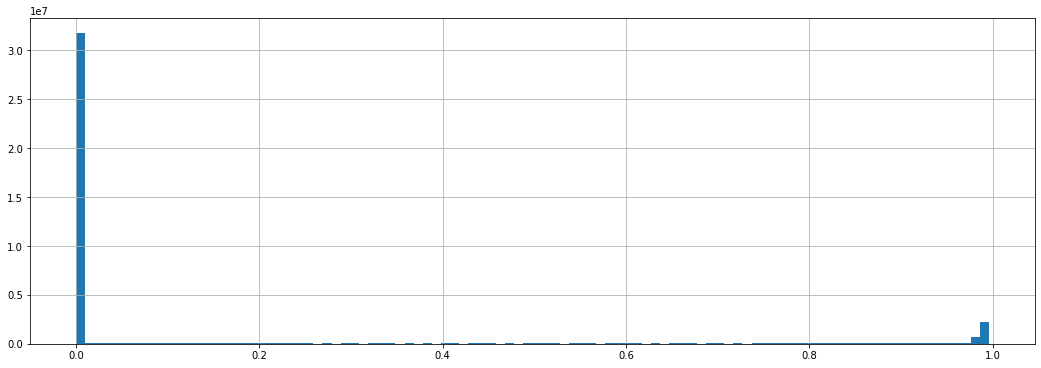

In [5]:
fig = figure(0, (18,6))
hist(x_train.ravel(), 100);grid(1)

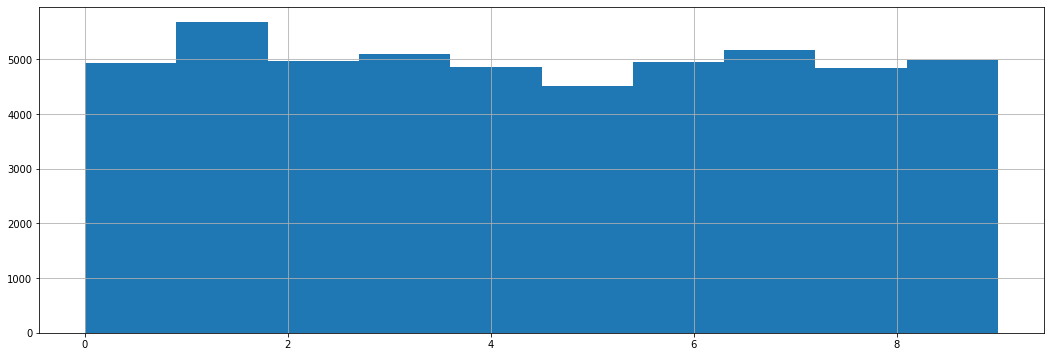

In [6]:
fig = figure(0, (18,6))
hist(y_train.ravel(), 10); grid(1)

![](../graphics/spacer_small.png)

## 2. Stochastic Gradient Descent
---

- Before we start training, let's think about the **size** of our dataset. 
- With 50k training examples, this trainig set in one of the large datasets we've seen so far. 
- And as you may already know, some of the datasets used in deep learning have **millions of examples**. 
- As you can imagine, computing the gradient of our loss with respect to our weights can be very computationally expensive when we process so many examples at once!
- Methods like that this use the entire dataset to compute the gradient are called **batch** or deterministic gradient methods. 
- A nice alternative is to use a **random sample** of our dataset to compute an estimate of the grandient at each step. These methods are generally called **minibatch**, **minibatch stochastic**, or just **stochastic**.
- Stochastic gradient descent offers large speedups, and can even have a nice regularizing effect, potentially reducing overfitting. 
- Section 8.1 of Goodfellow's Deep Learning book provides some nice tips for choosing minibatch size:

![](../graphics/minibatch_size_consderations-01.png)

- **Stochastic Gradient Descent** has mostly become standard practice when trainig deep neural networks. 
- PyTorch even includes A `DataLoader` class that can break our large data matrices into minibatches for us, that shuffles the data for us (to make sure that we don't see the same minibatch each epoch), and even supports multi-threading:

In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train_ds = TensorDataset(torch.tensor(x_train, dtype = torch.float), torch.tensor(y_train, dtype = torch.float))
train_dl = DataLoader(train_ds, batch_size=64, shuffle = True, num_workers = 4, drop_last = True)

In [8]:
train_dl

- The Pytorch `DataLoader` returns a python iterator. Iterators can be stepped through using loops (e.g. `for x, y in train_dl:`).  
- We can get a single item from an iterator using `next`.

In [9]:
x, y = next(iter(train_dl))

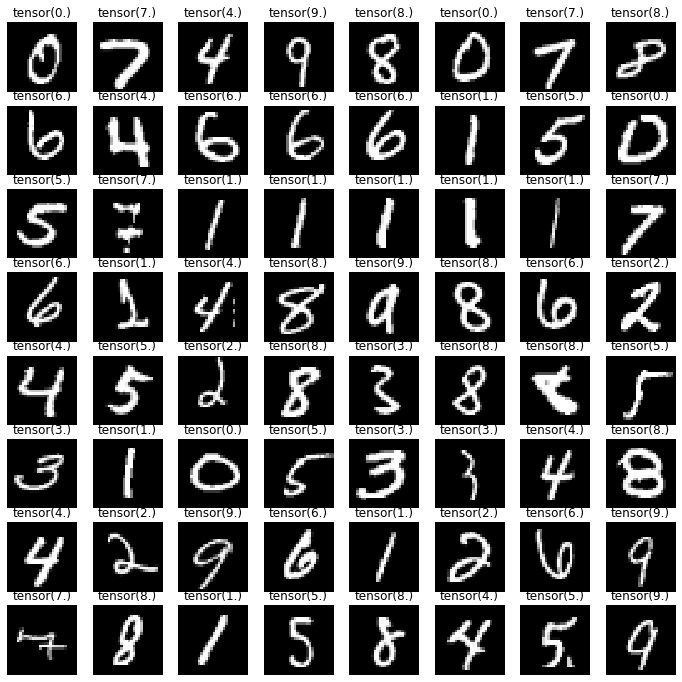

In [10]:
fig = figure(0, (12, 12))
for i in range(64):
    fig.add_subplot(8,8,i+1)
    imshow(x[i, :].reshape(28, 28), cmap = 'gray')
    title(str(y[i])); axis('off')

In [11]:
#Create a dataloader for the validation set:
valid_ds = TensorDataset(torch.tensor(x_valid, dtype = torch.float), torch.tensor(y_valid, dtype = torch.float))
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle = True, num_workers = 4, drop_last = True)

![](../graphics/spacer_small.png)

## 3. How Do We Make Our Regression Model Into a Classification Model?
---

- Let's start with a model very similar to the models we've used in the past for regression problems.


In [12]:
from torch import nn
from torch import optim
from tqdm import tqdm

In [13]:
#Simple 2 layer neural network with sigmoid acivation function
model = nn.Sequential(nn.Linear(784, 64),
                       nn.Sigmoid(), 
                       nn.Linear(64, 1))

- Since in this case our labels are just numbers, one really simple option here is to just try to **directly predict the label**. 
- Notice that we've removed the final Sigmoid activation function we had on our regression model to allow our model to predict numerical values between 0 and 9. 
- Why is the input dimnsion of our model 784?
- Alright, let's try training out network just like we trained our regression models.

In [14]:
num_epochs = 2; #An epoch corresponds to one complete pass through our training data. 
lr = 1e-5; losses = [] #Error seems to explode for larger learning rates.

opt = optim.SGD(model.parameters(), lr=lr) #pass in the parameters we want to optimize. 
for i in range(num_epochs):
    for x, y in tqdm(train_dl):
        yhat = model(x)
        loss = torch.sum(0.5*(y-yhat)**2)
        loss.backward() 

        opt.step() 
        opt.zero_grad()
        losses.append(loss.item())

100%|██████████| 781/781 [00:02<00:00, 276.43it/s]


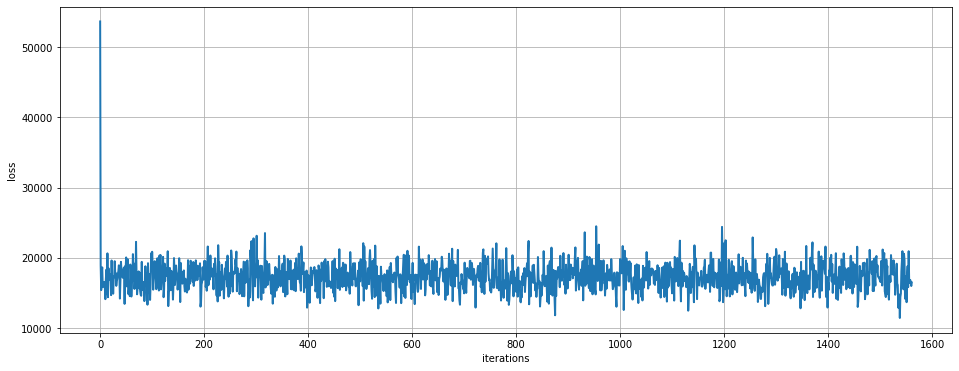

In [15]:
fig = figure(0, (16,6))
plot(losses, linewidth = 2); grid(1); xlabel('iterations'); ylabel('loss');

- Ok, it looks like our loss function went down, how is our model doing?

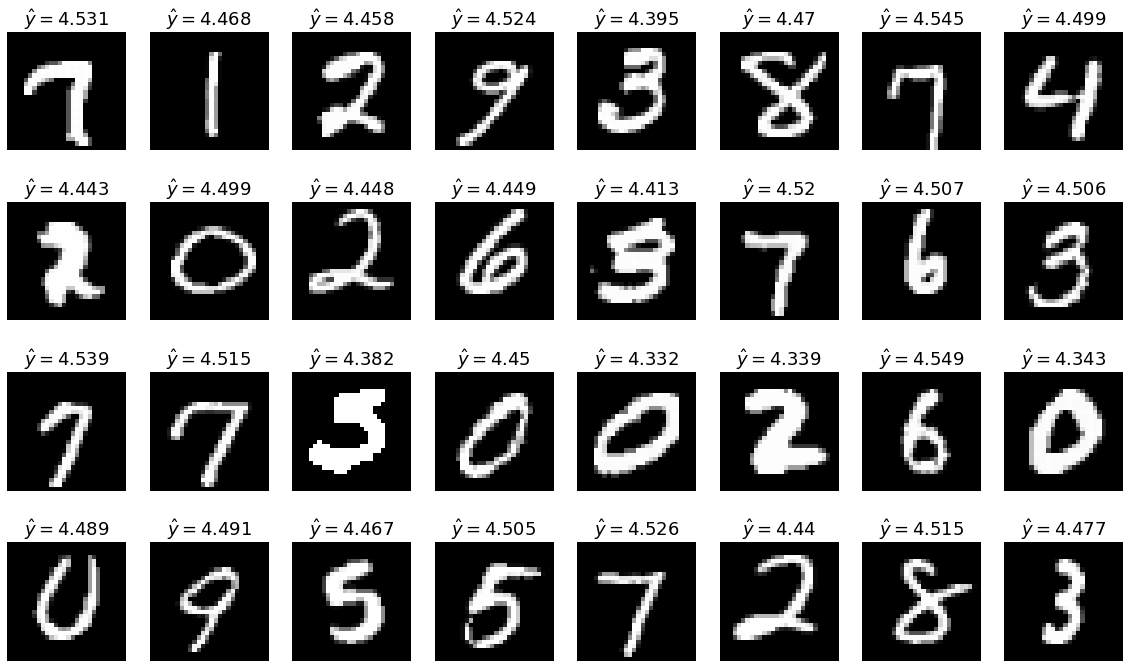

In [16]:
x, y = next(iter(valid_dl)) #Grab a validation minibatch
model.eval() #Put model into evaluation mode
yhat = model(x)

fig = figure(0, (20, 12))
for i in range(32):
    fig.add_subplot(4,8,i+1)
    imshow(x[i, :].reshape(28, 28), cmap = 'gray')
    title('$\hat{y} = $' + str(round(yhat[i].item(), 3)), fontsize = 18); axis('off')

- Alright, how did we do?
- Why?

![](../graphics/spacer_small.png)

- As you can see, our predictions are not great. 
- If you look closely, you'll notice that all our predictions are pretty close to the mean of our labels, 4.5. 
- Our network has **learned to predict the mean.** This is not uncommon when experimenting with neural networks. When this happens to me, I usually first check my normalization - is the scale of my inputs and outputs reasonable? (e.g. between 0 and 1 or -1 and 1 for my inputs, and does the scale of my ouputs match the ouput of my network). If this is not this issue, a good place to look next is the cost function. 
- Let's give our cost function some thought:

````
        yhat = model(x)
        loss = torch.sum(0.5*(y-yhat)**2)
````

- Remember that we're trying to directly predict the correct numerical label (0-9) with our neural network. 
- What might be problematic with this approach?
- Part of the reason for this is that if we treat this problem as a regression problem, we're imposing **ordinality** in our predictions. 
- For example, by using the root mean square error between our predictions and targets, we're penalizing our errors in an inconsistent manner. If our prediction target is 4 and our network predicts 5, this would be penalized less than predicting a 9. However, 5 and 9 are equally wrong. Our loss function does not reflect what we would like our network to learn.
- **one hot encoding** provides a nice solution to this problem, by expanding the dimension of our prediction targets - creating one dimension for each discrete class we would like to predict.

![](../graphics/spacer_small.png)

## 4. One Hot Encoding
---

In [17]:
import torch.nn.functional as F

In [18]:
x, y = next(iter(train_dl))
y_one_hot = F.one_hot(y.long(), num_classes=10)

In [19]:
y_one_hot[:5, :]

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])

- What are the handwritten digit values for each row in our one-hot-encoded matrix above?
- Let's try to train our network again, this time using the **mean square error** between our one-hot encoded labels and predictions. 
- We'll change our network to output 10 numbers for each image (one for each class)
- We'll also add a sigmoid activation to our final layer. We don't technically have to do this, but it my improve performance by better matching our network to what we're trying to predict (values between 0 and 1).

In [20]:
#Simple 2 layer neural network with sigmoid acivation function
model = nn.Sequential(nn.Linear(784, 64),
                       nn.Sigmoid(), 
                       nn.Linear(64, 10), 
                       nn.Sigmoid()) #We're now predicting values between 0 and 1

In [21]:
num_epochs = 25; lr = 1e-3; losses = [] #Lower epochs here to save time

opt = optim.SGD(model.parameters(), lr=lr) #pass in the parameters we want to optimize. 
for i in range(num_epochs):
    for x, y in tqdm(train_dl):
        yhat = model(x)
        y_one_hot = F.one_hot(y.long(), num_classes=10)
        
        loss = torch.sum(0.5*(y_one_hot.float()-yhat)**2)
        loss.backward() 

        opt.step() 
        opt.zero_grad()
        losses.append(loss.item())

100%|██████████| 781/781 [00:02<00:00, 351.79it/s]


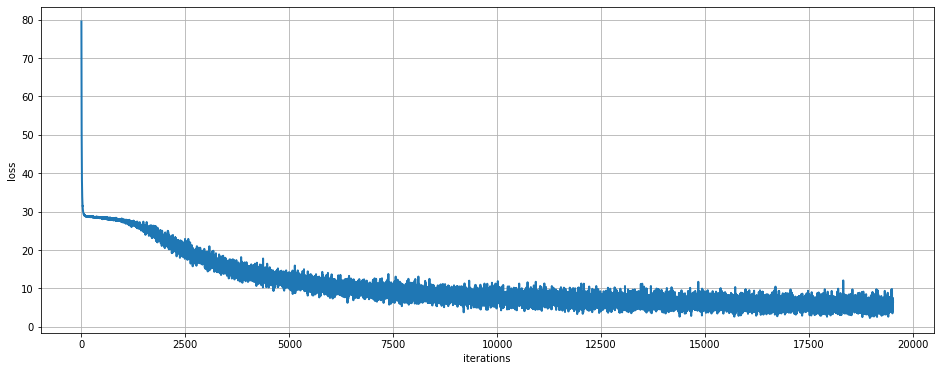

In [22]:
fig = figure(0, (16,6))
plot(losses, linewidth = 2); grid(1); xlabel('iterations'); ylabel('loss');

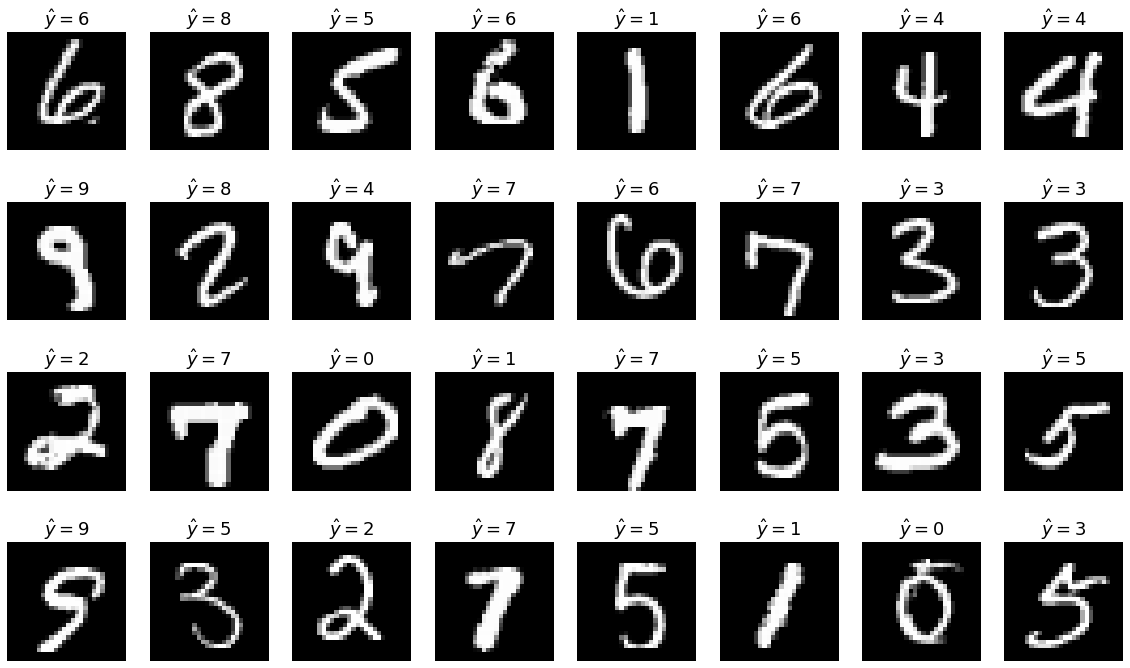

In [23]:
x, y = next(iter(valid_dl)) #Grab a validation minibatch
model.eval() #Put model into evaluation mode
yhat = model(x)
max_values, max_indices = torch.max(yhat, dim=1)

fig = figure(0, (20, 12))
for i in range(32):
    fig.add_subplot(4,8,i+1)
    imshow(x[i, :].reshape(28, 28), cmap = 'gray')
    title('$\hat{y} = $' + str(max_indices[i].item()), fontsize = 18); axis('off')

In [24]:
#Measure Accuracy on complete validation set:
x = torch.tensor(x_valid, dtype = torch.float)
y = torch.tensor(y_valid, dtype = torch.long)
yhat = model(x)
max_values, max_indices = torch.max(yhat, dim=1)
accuracy = (max_indices.eq(y).sum().float()/len(y)).item()
accuracy

0.9168000221252441

- Much better!
- Our results aren't prefect, but we definitely are not just predicting the mean!
- Now, despite this improvement, you may be surprised to find out that **pretty much no one trains classifiers this way**. 
- As we'll see, there's a much more effective loss funciton we can use for classification problems. 

## 5. Cost Functions Matter
---

- Up until this point, we've been minimizing the **Mean Square Error (MSE)** between our one-hot-encoded labels and predictions:

```
loss = torch.sum(0.5*(y_one_hot.float()-yhat)**2)
```

- Let's take a moment and give our loss function some thought. 
- How does our cost function shape the landscape we must tranverse as we perform gradient descent?
- Let's use a simplified example to give this some thought. 
- Instead of predicting all 10 mnist classes, let's for a moment just consider predicting 2, for example, only learning to classify 0s and 1s. 


![](../graphics/binary_mnist_network-01.png)

- Here's a visualization of the surface of our cost as a function of our output layer activities, $z_0, z_1$, after assuming that we're only predicting 2 classes instead of 10. 
- Now, the *real cost function surface* we're interested in the the cost function with respect to our weights. However, visualizing the cost function from the pespective of our final layer outputs $z$ as shown above can help us understand what's going on here, becuase the one of the first steps of backpropogation will involve computing $\frac{\partial \hat{y}}{\partial z}$, which is proportional to the gradient of the surface shown above. Further, our final gradient value will be multiplied by $\frac{\partial \hat{y}}{\partial z}$, so large or small values of $\frac{\partial \hat{y}}{\partial z}$ could have a large impact. 
- Now, **what possible issues might the landscape of our MSE cost function present?**

![](../graphics/spacer_small.png)

![](../graphics/goodfellow_quote_two-01.png)

![](../graphics/spacer_small.png)

- Now, before we go about looking for a better cost function, we need to make one more adjustment. 
- Instead of using one sigmoid on each output in our final layer, let's consider using the **softmax function** across our output vector:
$$
softmax(z_i) = \frac{exp(z_i)}{\sum_j exp(z_j)}
$$
- The softmax function is a nice differentiable function that allows us to better represent our probability distribution accross our $n$ classes. 
- Since our mnist classes are mutually exclusive, we would like our model to ouput a strong signal for the class it is most "confident" about and small number otherwise.
- The softmax function makes the largest output of our network larger relative to our other inputs, while enforcing that all of our outputs sum to one
- One way to think about softmax is as a **winner take all** function.

![](../graphics/softmax_examples-01.png)

- Note that the softmax output numbers above have been rounded - this will be important later, as an output value of 0 would be problematic.
- So we'll remove the individual sigmoid activations functions from the output of our model and replace them with a single softmax function. 
- **Disclaimer: you should only use softmax if your labels are mutually exclusive**. If your trying to classify cats vs dogs, and some of your images have both cats and dogs, softmax will force your network to predict a single class in this case!
- Now, let's return to searching for a cost function that won't squish our gradient as our current MSE cost function does. 

![](../graphics/spacer_small.png)

### 5.1 Maximum Likelihood Estimation
---

- As we saw above, mean square error (MSE) may not be an ideal loss function for classification problems, due to the gradient squishing flat regions in our loss function landscape. 
- So if MSE isn't so great, how should we go about finding a better loss function?
- One commonly used guiding principle for this type of problem is the idea of  **maximum Likelihood**. 
- "Most modern neural networks are trained using maximum likelihood." - Goodfellow et al 6.2.1.1
- Instead of guessing at better cost function for training our neural network, we'll use the **maximum likelihood principle** (See Goodfellow et al section 5.5 for a nice description)
- In a nutshell, given a model with parameters $\boldsymbol{\theta}$ (these would be the weights and biases of our neural network), we're seeking to find a set of values $\boldsymbol{\theta}_{ML}$ that maximize the probability of our labels given our data (Goodfellow equation 5.62):

$$
\boldsymbol{\theta}_{ML} = \underset{\boldsymbol{\theta}}{arg \, max} \, P(\boldsymbol{Y} \, | \, \boldsymbol{X}; \boldsymbol{\theta})
$$

- If we assume that our examples are i.i.d. (independent and identically distributed), then we can write our probability as a product across our individual examples:

$$
\boldsymbol{\theta}_{ML} = 
\underset{\boldsymbol{\theta}}{arg \, max} \, 
\prod_{i=1}^m
P(\boldsymbol{y}^{(i)} \, | \, \boldsymbol{x}^{(i)}; \boldsymbol{\theta})
$$

- Products over probabilities can be numerically difficult to work with. A common way around this issue here is to take the logarithm of our likelihood:
$$
\boldsymbol{\theta}_{ML} = 
\underset{\boldsymbol{\theta}}{arg \, max} \, 
\sum_{i=1}^m log
P(\boldsymbol{y}^{(i)} \, | \, \boldsymbol{x}^{(i)}; \boldsymbol{\theta})
$$

- From description from [Likelihood function Wikipedia article](https://en.wikipedia.org/wiki/Likelihood_function#Log-likelihood): "For many applications, the natural logarithm of the likelihood function, called the log-likelihood, is more convenient to work with. This is because we are generally interested in where the likelihood reaches its maximum value: the logarithm is a strictly increasing function, so the logarithm of a function achieves its maximum value at the same points as the function itself, and hence the log-likelihood can be used in place of the likelihood in maximum likelihood estimation and related techniques.

### **But how do we make this into a cost function?**

- The log likelihood expression above is interesting, but (for me at least), it's not immediately obvious how to turn it into a cost function for us to minimize. 
- The trickiest part is probably the probability, this depends on the distribution assumed by model we're using. If we were solving a binary classification problem, we may assume a bernoulli distribution, or if we were solving a regression problem we assume a gaussian distribution. In our current model we've assumed a softmax or "multinoulli" distribution - so we need to take this into account when deriving a cost function from our log likelihood expression aobve. 
- One of my favorite derivations I've come accross so far comes from a [stack exchange answer](https://datascience.stackexchange.com/questions/9302/the-cross-entropy-error-function-in-neural-networks), Here's the derivation below. 
- One minor note - we take the **negative** log likelihood here, becuase we're interested in computing a cost function to **minimize**, rather than maximizing the probability of our labels given our data and weights. 

---

One way to interpret cross-entropy is to see it as a (minus) log-likelihood for the data $y_i'$, under a model $y_i$.

Namely, suppose that you have some fixed model (a.k.a. "hypothesis"), which predicts for $n$ classes $\{1,2,\dots, n\}$ their hypothetical occurrence probabilities $y_1, y_2,\dots, y_n$. Suppose that you now observe (in reality) $k_1$ instances of class $1$, $k_2$ instances of class $2$, $k_n$ instances of class $n$, etc. According to your model the likelihood of this happening is:
$$
P[data|model] := y_1^{k_1}y_2^{k_2}\dots y_n^{k_n}.
$$
Taking the logarithm and changing the sign:
$$
-\log P[data|model] = -k_1\log y_1 -k_2\log y_2 - \dots -k_n\log y_n = -\sum_i k_i \log y_i
$$
If you now divide the right-hand sum by the number of observations $N = k_1+k_2+\dots+k_n$, and denote the empirical probabilities as $y_i'=k_i/N$, you'll get the cross-entropy:
$$
-\frac{1}{N} \log P[data|model] = -\frac{1}{N}\sum_i k_i \log y_i = -\sum_i y_i'\log y_i =: H(y', y)
$$

---

- The derivation above uses slightly different variable names, using our convention:
$$
cost = - \sum_i y_i log(\hat{y_i})
$$

- Where $i$ sums over our output classes. 
- Let's consider the binary classification case (only 2 classes), and expand this equation.
- In this case, we can simplify things a bit since we know that under our softmax distribution, our outputs must add to one: $y_0 = 1-y_1$.

$$
cost = - y \cdot log(\hat{y}) - (1-y) \cdot log(1-\hat{y})
$$

- Let's visualize our cost as a function of our predictions $\hat{y}$ for the binary case. 

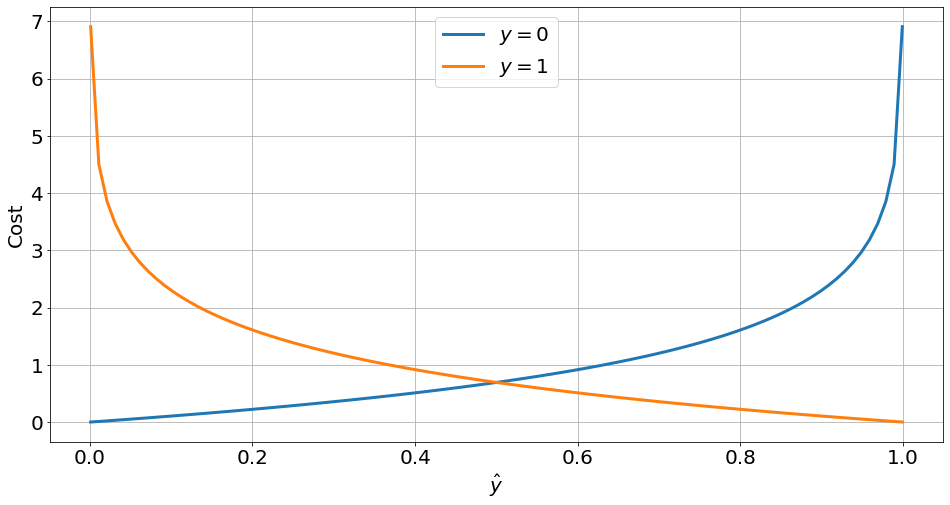

In [25]:
import numpy as np
from matplotlib.pyplot import *

# Let's visualize our cost function values across a range of yhats softmax output values over the range (0, 1)
yhat = np.linspace(0.001, 0.999, 100)

#First the case if our label is 0
y = 0 
cost = - y*np.log(yhat) - (1-y)*np.log(1-yhat)
fig = figure(0, (16, 8))
ax = fig.add_subplot(111)
plot(yhat, cost, linewidth = 3)

#Now the case if our label is 1
y = 1 
cost = - y*np.log(yhat) - (1-y)*np.log(1-yhat)
plot(yhat, cost, linewidth = 3); grid(1)

legend(['$y=0$', '$y=1$'], fontsize = 20); xlabel('$\hat{y}$', fontsize = 20)
ylabel('Cost', fontsize = 20); ax.tick_params(axis='both', which='major', labelsize=20)

- Note that when $\hat{y} = y$ our cost is zero, our cost increases as we move away from the correct label, and becomes very large as our prediction moves close to the completely wrong label. 
- Our model is penalized heavity when our predictions are very wrong.

### 5.2 Cross Entropy Loss
----

- Alright, so after all that work we know have a cost function derived from the principle of **maximum likelihood**:

$$
cost = - \sum_i y_i log(\hat{y_i})
$$

- This loss function is often refered to the **cross entropy**, this is a little bit of a misnomer:

>"Many authors use the term "cross-entropy" to identify specifically the negative log-likelihood of a Bernoulli or softmax distribution, but that is a misnomer. Any loss consisting of a negative log-likelihood is a cross-entropy between the empirical distribution defined by the training set and the probability distribution defined by the model. For example, mean square error is the cross-entropy between the empirical distributionand a Guassian model." - Goodfellow et al section 5.5

- Let's put all of this together:

![](../graphics/binary_mnist_network_cross_entropy-01.png)

- Note that we don't have those annoying gradient-killing flat spots that we had in our mean square cost function above.
- Now, softmax will **saturate** just as a sigmoid activations functions do, however, the log form our cross entropy loss function has the nice effect of **reversing** the exponential in our softmax function, and making our cost function surface fairly linear, with a nice large downhill gradient. 
- Now, an important question:

![](../graphics/question_one-01.png)

![](../graphics/spacer_small.png)

- Let's find out!
- We'll re-load our data here, just in case we've started a new session or something.

In [26]:
import numpy as np
from pathlib import Path
from matplotlib.pyplot import *
import pickle, gzip
from tqdm import tqdm

DATA_PATH = Path("../data")
PATH = DATA_PATH / "mnist"
FILENAME = "mnist.pkl.gz"

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

#Create dataloaders
train_ds = TensorDataset(torch.tensor(x_train, dtype = torch.float), torch.tensor(y_train, dtype = torch.long))
train_dl = DataLoader(train_ds, batch_size=64, shuffle = True, num_workers = 4, drop_last = True)

valid_ds = TensorDataset(torch.tensor(x_valid, dtype = torch.float), torch.tensor(y_valid, dtype = torch.long))
valid_dl = DataLoader(valid_ds, batch_size=256, shuffle = True, num_workers = 4, drop_last = True)

### MSE Loss Baseline

In [28]:
#Simple 2 layer neural network with sigmoid acivation function
model = nn.Sequential(nn.Linear(784, 800),
                       nn.Sigmoid(), 
                       nn.Linear(800, 10), 
                       nn.Sigmoid()) #We're now predicting values between 0 and 1

In [29]:
num_epochs = 25; lr = 1e-3; accuracies_mse = [] #Lower epochs here to save time

opt = optim.SGD(model.parameters(), lr=lr) #pass in the parameters we want to optimize. 
for i in range(num_epochs):
    model.train() #Put in training mode
    for x, y in train_dl:
        yhat = model(x)
        y_one_hot = F.one_hot(y.long(), num_classes=10)
        
        loss = torch.sum(0.5*(y_one_hot.float()-yhat)**2)
        loss.backward() 

        opt.step(); opt.zero_grad();
    
    #Check validation loss and accuracy at the end of each epoch:
    model.eval() #Put in evaluation mode!
    with torch.no_grad():
        x, y = next(iter(valid_dl)) #Just measure on one minibatch
        yhat = model(x)
        max_values, max_indices = torch.max(yhat, dim=1)
        accuracy = (max_indices.eq(y).sum().float()/len(y)).item()
        accuracies_mse.append(accuracy)
        print('Epoch: ' + str(i+1) + ', training loss = ' + str(round(loss.item(), 3)) + \
              ', valid accuracy = ' + str(round(accuracy, 3)))

Epoch: 1, training loss = 26.687, valid accuracy = 0.457
Epoch: 2, training loss = 20.937, valid accuracy = 0.637
Epoch: 3, training loss = 15.422, valid accuracy = 0.785
Epoch: 4, training loss = 14.824, valid accuracy = 0.852
Epoch: 5, training loss = 9.608, valid accuracy = 0.828
Epoch: 6, training loss = 11.404, valid accuracy = 0.867
Epoch: 7, training loss = 9.55, valid accuracy = 0.859
Epoch: 8, training loss = 8.77, valid accuracy = 0.859
Epoch: 9, training loss = 8.917, valid accuracy = 0.859
Epoch: 10, training loss = 7.801, valid accuracy = 0.879
Epoch: 11, training loss = 6.614, valid accuracy = 0.887
Epoch: 12, training loss = 7.95, valid accuracy = 0.875
Epoch: 13, training loss = 10.059, valid accuracy = 0.875
Epoch: 14, training loss = 7.638, valid accuracy = 0.891
Epoch: 15, training loss = 6.649, valid accuracy = 0.883
Epoch: 16, training loss = 7.882, valid accuracy = 0.891
Epoch: 17, training loss = 6.432, valid accuracy = 0.922
Epoch: 18, training loss = 4.97, vali

## Cross Entropy Loss

In [30]:
#Simple 2 layer neural network with sigmoid acivation function
model = nn.Sequential(nn.Linear(784, 800),
                       nn.Sigmoid(), 
                       nn.Linear(800, 10))

In [31]:
num_epochs = 25; lr = 1e-1; accuracies_cross_entropy = [] #We can use a higher learning rate with cross entroy loss. 

opt = optim.SGD(model.parameters(), lr=lr)
for i in range(num_epochs):
    for x, y in train_dl:
        yhat = model(x)
        loss = F.cross_entropy(yhat, y) #Takes care of softmax and one hot encoding for us!
        loss.backward() 
        opt.step(); opt.zero_grad();
    
    #Check validation loss and accuracy at the end of each epoch:
    model.eval() #Put in evaluation mode!
    with torch.no_grad():
        x, y = next(iter(valid_dl)) #Just measure on one minibatch
        yhat = model(x)
        max_values, max_indices = torch.max(yhat, dim=1)
        accuracy = (max_indices.eq(y).sum().float()/len(y)).item()
        accuracies_cross_entropy.append(accuracy)
        print('Epoch: ' + str(i+1) + ', training loss = ' + str(round(loss.item(), 3)) + \
              ', valid accuracy = ' + str(round(accuracy, 3)))

Epoch: 1, training loss = 0.354, valid accuracy = 0.91
Epoch: 2, training loss = 0.263, valid accuracy = 0.895
Epoch: 3, training loss = 0.363, valid accuracy = 0.918
Epoch: 4, training loss = 0.25, valid accuracy = 0.895
Epoch: 5, training loss = 0.156, valid accuracy = 0.898
Epoch: 6, training loss = 0.175, valid accuracy = 0.926
Epoch: 7, training loss = 0.24, valid accuracy = 0.918
Epoch: 8, training loss = 0.21, valid accuracy = 0.914
Epoch: 9, training loss = 0.325, valid accuracy = 0.941
Epoch: 10, training loss = 0.466, valid accuracy = 0.957
Epoch: 11, training loss = 0.428, valid accuracy = 0.922
Epoch: 12, training loss = 0.531, valid accuracy = 0.926
Epoch: 13, training loss = 0.224, valid accuracy = 0.918
Epoch: 14, training loss = 0.118, valid accuracy = 0.938
Epoch: 15, training loss = 0.247, valid accuracy = 0.902
Epoch: 16, training loss = 0.121, valid accuracy = 0.957
Epoch: 17, training loss = 0.396, valid accuracy = 0.961
Epoch: 18, training loss = 0.176, valid accu

Text(0, 0.5, 'Accuracy')

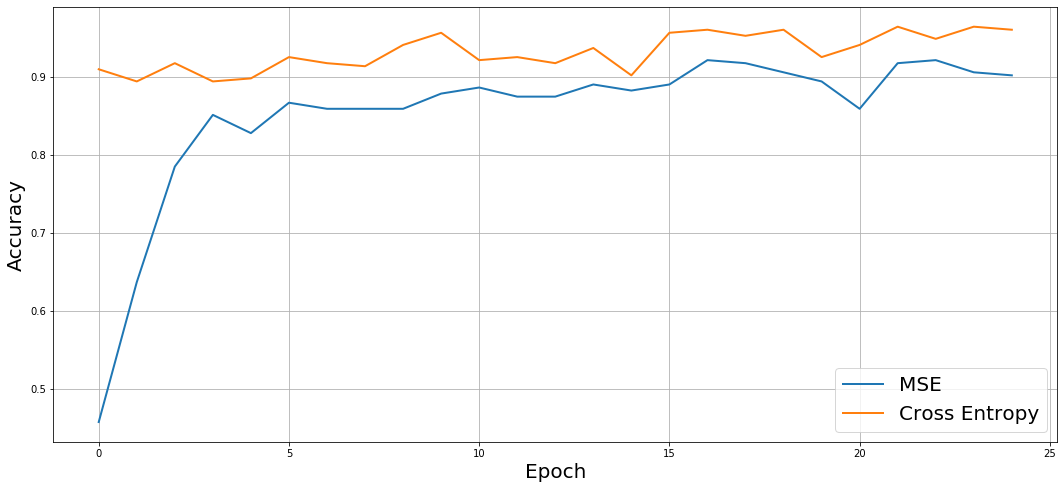

In [32]:
fig = figure(0, (18, 8))
plot(accuracies_mse, linewidth = 2); plot(accuracies_cross_entropy, linewidth = 2); grid(1)
legend(['MSE', 'Cross Entropy'], fontsize = 20); xlabel('Epoch', fontsize = 20); ylabel('Accuracy', fontsize = 20)

- Cross Entropy Cost Achieves Higher Performance *and* Converges Faster than MSE on this example!
- This is not always the case, but generally cross entropy is a better choice than MSE for classification problems. 
- You can compare lots of architectures and loss functions on the [MNIST Leaderboard](http://yann.lecun.com/exdb/mnist/)

## 6. Let's Get Deep!
---

- So far, we've made some good progress with **stochastic gradient descent** and **cross entropy loss**, but all of our networks have only been one layer deep!
- If you've been paying attention, I'm sure you're wondering when we're going to actually see a **deep neural network**. 
- Let's build one, right now. 
- As you may know, the deep neural networks are just neural networks with multiple layers of neurons. 
- Let's start with 5 layers, and see how we do!
- We'll monitor a few extra things as we train to see how we're doing.

In [33]:
from IPython import display

In [34]:
# Deep Neural Network! Look at all those layers :)
model = nn.Sequential(nn.Linear(784, 1024), nn.Sigmoid(), 
                      nn.Linear(1024, 128), nn.Sigmoid(),
                      nn.Linear(128, 64), nn.Sigmoid(),
                      nn.Linear(64, 32), nn.Sigmoid(),
                      nn.Linear(32, 10)) 

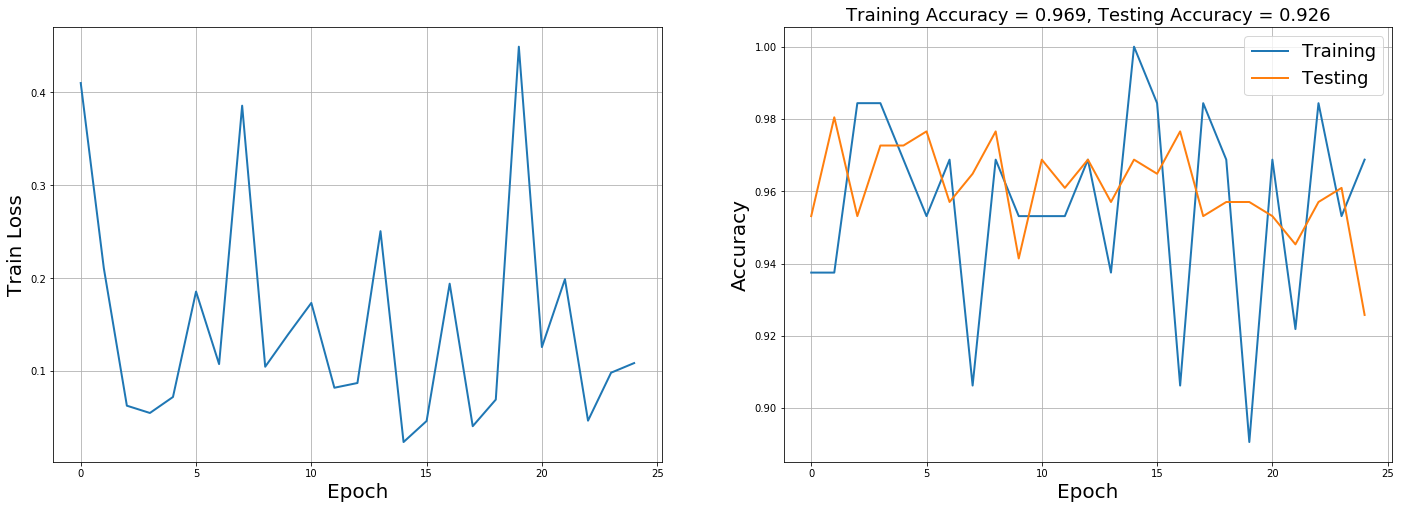

<Figure size 432x288 with 0 Axes>

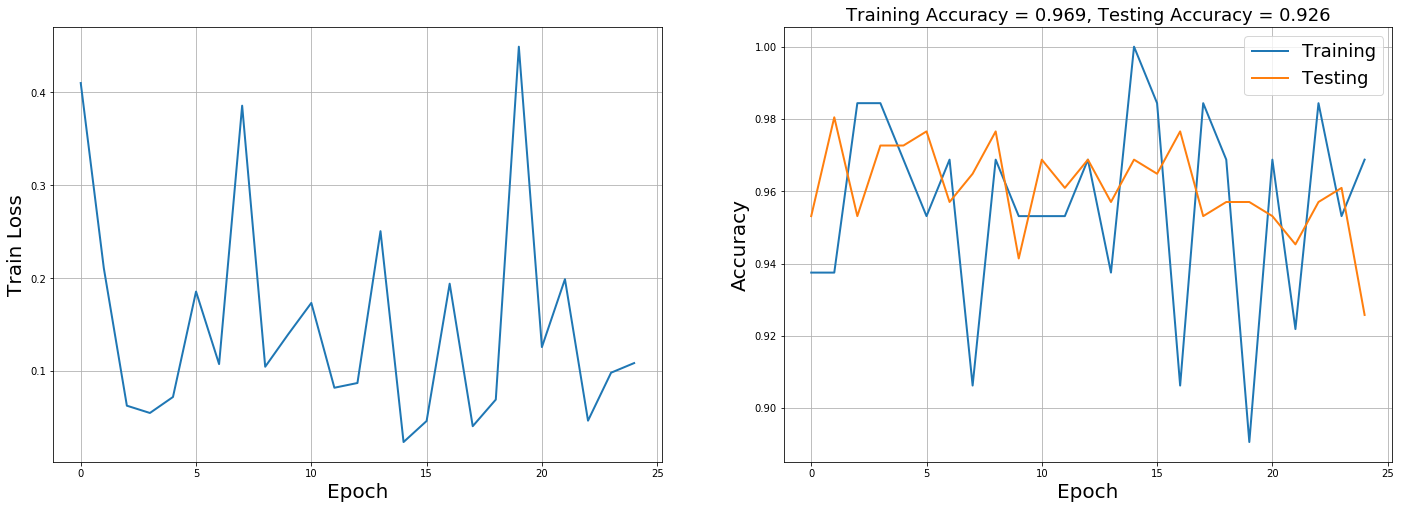

In [35]:
num_epochs = 25; lr = 1e-2; 
loss_train = [] 
acc_train = []
acc_test = [] 

opt = optim.Adam(model.parameters(), lr=lr) #Had to switch to the Adam optimizer to get thing to actually train.
for i in range(num_epochs):
    for x, y in train_dl:
        yhat = model(x)
        loss = F.cross_entropy(yhat, y) #Takes care of softmax and one hot encoding for us!
        loss.backward() 
        opt.step(); opt.zero_grad();
    
    #Check validation loss and accuracy at the end of each epoch:
    model.eval() #Put in evaluation mode!
    with torch.no_grad():
        max_values, max_indices = torch.max(yhat, dim=1)
        acc_train.append((max_indices.eq(y).sum().float()/len(y)).item())
        loss_train.append(loss.item())
        
        x, y = next(iter(valid_dl))
        yhat = model(x)
        max_values, max_indices = torch.max(yhat, dim=1)
        accuracy = (max_indices.eq(y).sum().float()/len(y)).item()
        acc_test.append(accuracy)
        
        #Visualize as we train
        clf(); fig = figure(0, (24, 8));
        fig.add_subplot(1,2,1)
        plot(loss_train, linewidth = 2); xlabel('Epoch', fontsize = 20); ylabel('Train Loss', fontsize = 20); grid(1)
        fig.add_subplot(1,2,2)
        plot(acc_train, linewidth = 2); plot(acc_test, linewidth = 2);
        legend(['Training', 'Testing'], fontsize = 18); grid(1)
        xlabel('Epoch', fontsize = 20); ylabel('Accuracy', fontsize = 20); 
        title('Training Accuracy = ' + str(round(acc_train[-1], 3)) + \
              ', Testing Accuracy = ' + str(round(accuracy, 3)), fontsize = 18)
        display.clear_output(wait=True); display.display(gcf())

In [36]:
#Measure Accuracy on complete validation set for better accuracy estimate:
x = torch.tensor(x_valid, dtype = torch.float)
y = torch.tensor(y_valid, dtype = torch.long)
yhat = model(x)
max_values, max_indices = torch.max(yhat, dim=1)
accuracy = (max_indices.eq(y).sum().float()/len(y)).item()
accuracy

0.9569000005722046

- **Anything concerning about our finaly accuracy plot?**
- As you may have noticed, we appear to be overfitting!
- Now, we are acheiving our best test set accuracy thusfar, **around 96-97%**. 
- Now, this would be impressive, if Yann Lecun hadn't [beaten this performance](http://yann.lecun.com/exdb/mnist/) with a smaller network way back in 1998 with his **LeNet-5 network**, achieving a test set accuracy of **99.05%**. 
- It seems like there may be more to training deep networks than just stacking layers. 
- Next time, we'll have a look at Yann Lecun's LeNet-5 network.

![](../graphics/cartoon-01.png)